In [1]:
# %autosave 0

In [2]:
import sys
from pathlib import Path
from os import getcwd
sys.path.append(str(Path(getcwd()).parent))
from os import remove


from datetime import date, timedelta
import codecs
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

from os.path import join, basename

from bulletin import default_input, default_output, root
from bulletin.services.metabase import Metabase
from bulletin.systems.casos_confirmados import CasosConfirmados
from bulletin.systems.notifica import Notifica
from bulletin.utils.static import Municipios
from bulletin.utils.normalize import normalize_hash, normalize_labels, normalize_text, date_hash, normalize_number
from bulletin.utils import static
from bulletin.utils.xls_ import fit_cols

from datetime import datetime
import pyminizip as pz

today = datetime.today()
ontem = today - timedelta(1)
anteontem = ontem - timedelta(1)

municipios = Municipios()
municipios['mun_resid'] = municipios['municipio'].apply(normalize_text)
municipios.loc[municipios['uf']!='PR','mun_resid'] = municipios.loc[municipios['uf']!='PR','municipio'].apply(normalize_text) + '/' + municipios['uf']

import random
limite = 10462


---------------------------------------------------------------

root: C:\sesa\dev\bulletin
parent: C:\sesa\dev
default_input: C:\sesa\dev\input
default_output: C:\sesa\dev\output

---------------------------------------------------------------



In [3]:
mb = Metabase()
intervalo = "classificacao_final = 2 AND excluir_ficha = 2 AND status_notificacao in (1,2) AND ((data_notificacao >= NOW() - INTERVAL '7 DAY') or (data_liberacao >= NOW() - INTERVAL '7 DAY') or (updated_at >= NOW() - INTERVAL '7 DAY') or (data_coleta >= NOW() - INTERVAL '7 DAY') or (data_encerramento >= NOW() - INTERVAL '7 DAY'))"
mb.generate_notifica_query('update_notifica', where=intervalo)

limit: 100000
Cookie:'13646********-****-****-****-************27d89'
Select 44 columns


"SELECT id, to_char(data_notificacao,'DD/MM/YYYY') AS data_notificacao, to_char(data_encerramento,'DD/MM/YYYY') AS data_encerramento, status_notificacao, origem, to_char(updated_at,'DD/MM/YYYY') AS updated_at, numero_do, classificacao_final, criterio_classificacao, evolucao, to_char(data_cura_obito,'DD/MM/YYYY') AS data_cura_obito, tipo_paciente, cns, cpf, passaporte, etnia, paciente, sexo, to_char(data_nascimento,'DD/MM/YYYY') AS data_nascimento, nome_mae, raca_cor, ocupacao, ocupacao_descricao, cod_cbo, escolaridade, pais_residencia, pais_municipio_residencia, uf_residencia, ibge_residencia, cep_residencia, logradouro_residencia, bairro_residencia, uf_unidade_notifica, ibge_unidade_notifica, to_char(data_cadastro,'DD/MM/YYYY') AS data_cadastro, to_char(data_coleta,'DD/MM/YYYY') AS data_coleta, to_char(data_recebimento,'DD/MM/YYYY') AS data_recebimento, to_char(data_liberacao,'DD/MM/YYYY') AS data_liberacao, requisicao, resultado, exame, metodo, lab_executor, to_char(data_1o_sintomas,

In [4]:
update_notifica = mb.download_notificacao('update_notifica', load=False, normalize=True)
update_notifica.hashes()
update_notifica.save(replace=True)
len(update_notifica.df)

Download update_notifica

Requesting csv
Success code 200
Saving query in C:\sesa\dev\input\queries\update_notifica_len.csv
Download finish!
time elapsed: 0:00:03.665651
Columns size: 1


query_size: 30455

select ... limit 100000 offset 0

Requesting csv
Success code 200
Saving query in C:\sesa\dev\input\queries\tmp\update_notifica_0_100000.csv
Download finish!
time elapsed: 0:00:01.804228
Columns size: 44

['comorbidades', 'instituicao', 'notifica', 'update_notifica']
Reading C:\sesa\dev\input\queries\tmp\update_notifica_0_100000.csv
normalize notifica
Attrb
30454
reading Notifica time elepsed:00:00:52
Download query time elepsed:00:01:02
saving Notifica to pkl time elepsed:00:00:00


30454

In [5]:
notifica = Notifica()
notifica.load()
notifica.update(update_notifica.df)
notifica.hashes()
notifica.check_duplicates()
notifica.save(replace=True)
casos_notifica = notifica.df
len(notifica.df)

['comorbidades', 'instituicao', 'notifica', 'update_notifica']
loading Notifica from pkl time elepsed:00:00:05
novas_notificacoes 134
possiveis_atualizacoes 30320
duplicated in  hash_mae : 22787
duplicated in  hash_nasc : 31863
duplicated in  hash_resid : 25023
duplicated in  hash_atend : 23424
duplicated in  hash_diag : 16658
duplicated in  hash_lib : 8687
saving Notifica to pkl time elepsed:00:00:18


1203261

In [9]:
casos_notifica = pd.merge(casos_notifica.rename(columns={'ibge_residencia':'ibge'}),municipios[['ibge','rs','mun_resid','uf','municipio']],on='ibge',how='left').rename(columns={'ibge':'ibge_residencia'})
casos_notifica = pd.merge(casos_notifica.rename(columns={'ibge_unidade_notifica':'ibge'}),municipios[['ibge','mun_resid']].rename(columns={'mun_resid':'mun_atend'}),on='ibge',how='left').rename(columns={'ibge':'ibge_unidade_notifica'})
casos_notifica = casos_notifica.loc[(casos_notifica['data_diagnostico'].notna())&(~casos_notifica['duplicated'])&(casos_notifica['pais_residencia']==1)&(casos_notifica['mun_resid'].notna())]

casos_notifica = pd.merge(casos_notifica,pd.read_csv(join(root,'resources','tables','exame.csv')).rename(columns={'exame':'exame_name','id':'exame'}), on='exame', how='left')

casos_notifica = casos_notifica.loc[casos_notifica['sexo']!=3]
casos_notifica.loc[casos_notifica['sexo']==1,'sexo'] = 'M'
casos_notifica.loc[casos_notifica['sexo']==2,'sexo'] = 'F'

print(len(casos_notifica))
notifica.df.dtypes

1164447


id                                    int64
data_notificacao             datetime64[ns]
data_encerramento            datetime64[ns]
status_notificacao                    int32
origem                                int32
updated_at                   datetime64[ns]
numero_do                            object
classificacao_final                   int32
criterio_classificacao                int32
evolucao                              int32
data_cura_obito              datetime64[ns]
tipo_paciente                         int32
cns                                  object
cpf                                  object
passaporte                           object
etnia                                 int32
paciente                             object
sexo                                  int32
data_nascimento              datetime64[ns]
nome_mae                             object
raca_cor                              int32
ocupacao                              int32
ocupacao_descricao              

In [10]:
cc = CasosConfirmados()
cc.load()
cc.df.dtypes

['cc_19_06_2021']
loading Casos Confirmados from pkl time elepsed:00:00:03


hash_resid                       object
identificacao                     int64
id_notifica                       int32
uf_residencia                    object
ibge_residencia                   int32
ibge_unidade_notifica             int32
paciente                         object
sexo                             object
idade                             int32
exame                            object
data_diagnostico         datetime64[ns]
data_comunicacao         datetime64[ns]
data_1o_sintomas         datetime64[ns]
evolucao                          int32
data_evolucao            datetime64[ns]
data_com_evolucao        datetime64[ns]
hash_resid_less                  object
hash_resid_more                  object
hash_atend                       object
hash_atend_less                  object
hash_atend_more                  object
hash_diag                        object
dtype: object

In [11]:
casos_confirmados = cc.df
len(casos_confirmados)

1192936

In [12]:
casos_confirmados = pd.merge(casos_confirmados.rename(columns={'ibge_residencia':'ibge'}),municipios,how='left',on='ibge').rename(columns={'ibge':'ibge_residencia'})
casos_confirmados[['identificacao','evolucao']].groupby('evolucao').count()

,identificacao
evolucao,
1,832308
2,29975
3,330653


In [13]:
novos_casos = casos_notifica.loc[~(
    (casos_notifica['id'].isin(casos_confirmados['id_notifica'])) |
    (casos_notifica['hash_resid'].isin(casos_confirmados['hash_resid'])) |
    (casos_notifica['hash_resid'].isin(casos_confirmados['hash_resid_less'])) |
    (casos_notifica['hash_resid'].isin(casos_confirmados['hash_resid_more'])) |
    (casos_notifica['hash_atend'].isin(casos_confirmados['hash_atend'])) |
    (casos_notifica['hash_atend'].isin(casos_confirmados['hash_atend_less'])) |
    (casos_notifica['hash_atend'].isin(casos_confirmados['hash_atend_more'])) |
    (casos_notifica['hash_diag'].isin(casos_confirmados['hash_diag'])) |
    (casos_notifica['hash_lib'].isin(casos_confirmados['hash_diag']))
)].copy()


novos_casos['data_com'] = pd.to_datetime(date.today())
novos_casos = novos_casos.sort_values(['data_diagnostico','paciente'])

len(novos_casos)

49714

In [14]:
novos_casos.loc[novos_casos['paciente']=='LEOPOLDO MENDONCA DIAS']

,id,data_notificacao,data_encerramento,status_notificacao,origem,updated_at,numero_do,classificacao_final,criterio_classificacao,evolucao,data_cura_obito,tipo_paciente,cns,cpf,passaporte,etnia,paciente,sexo,data_nascimento,nome_mae,raca_cor,ocupacao,ocupacao_descricao,cod_cbo,escolaridade,pais_residencia,pais_municipio_residencia,uf_residencia,ibge_residencia,cep_residencia,logradouro_residencia,bairro_residencia,uf_unidade_notifica,ibge_unidade_notifica,data_cadastro,data_coleta,data_recebimento,data_liberacao,requisicao,resultado,exame,metodo,lab_executor,data_1o_sintomas,data_diagnostico,idade,duplicated,hash_mae,hash_nasc,hash_resid,hash_atend,hash_diag,hash_lib,rs,mun_resid,uf,municipio,mun_atend,exame_name,data_com


<AxesSubplot:xlabel='data_diagnostico'>

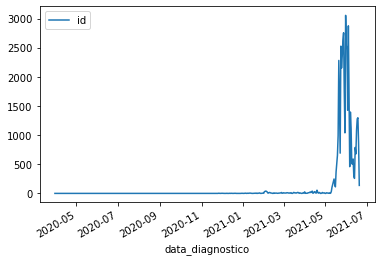

In [15]:
novos_casos[['id','data_diagnostico']].groupby('data_diagnostico').count().plot()

In [16]:
obitos_notifica = casos_notifica.loc[casos_notifica['evolucao']==2]
obitos_casos = casos_confirmados.loc[casos_confirmados['evolucao']==2]

novos_obitos = obitos_notifica.loc[~(
    (obitos_notifica['id'].isin(obitos_casos['id_notifica'])) |
    (obitos_notifica['hash_resid'].isin(obitos_casos['hash_resid'])) |
    (obitos_notifica['hash_resid'].isin(obitos_casos['hash_resid_less'])) |
    (obitos_notifica['hash_resid'].isin(obitos_casos['hash_resid_more'])) |
    (obitos_notifica['hash_atend'].isin(obitos_casos['hash_atend'])) |
    (obitos_notifica['hash_atend'].isin(obitos_casos['hash_atend_less'])) |
    (obitos_notifica['hash_atend'].isin(obitos_casos['hash_atend_more'])) |
    (obitos_notifica['hash_diag'].isin(obitos_casos['hash_diag'])) |
    (obitos_notifica['hash_lib'].isin(obitos_casos['hash_diag']))
)]

novos_obitos = novos_obitos.loc[novos_obitos['data_cura_obito'].notna()]
novos_obitos = novos_obitos.loc[novos_obitos['hash_resid'].isin(casos_confirmados['hash_resid'].tolist() + novos_casos['hash_resid'].tolist())]
novos_obitos = novos_obitos.sort_values(['paciente'])

novos_obitos = novos_obitos.loc[novos_obitos['data_cura_obito'].notna()]
len(novos_obitos)

21

<AxesSubplot:xlabel='data_cura_obito'>

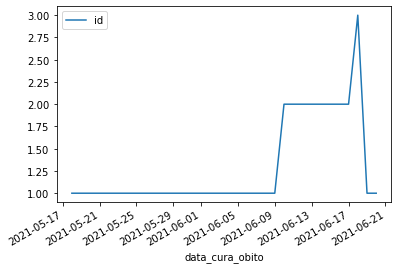

In [17]:
novos_obitos[['id','data_cura_obito']].groupby('data_cura_obito').count().plot()

In [18]:
dias_apos = [1,2,3,7,14,21,30,60,90]
dias_apos_label = ['hoje','24 horas','48 horas', '72 horas', '7 dias', '14 dias', '21 dias', '30 dias', '60 dias', '90 dias']

In [19]:
novos_obitos['dias_apos_obito'] = (today - novos_obitos['data_cura_obito']).dt.days
novos_obitos['periodo_obito'] = [ x for x in np.digitize(novos_obitos['dias_apos_obito'],dias_apos,right=False)]
periodo_novos_obitos = novos_obitos[['id','periodo_obito']].groupby('periodo_obito').count().rename(columns={'id':'qtde'})
periodo_novos_obitos['periodo'] = [ dias_apos_label[x] for x in periodo_novos_obitos.index ]
periodo_novos_obitos[['periodo','qtde']]

,periodo,qtde
periodo_obito,,
0,hoje,1
1,24 horas,1
2,48 horas,3
3,72 horas,8
4,7 dias,7
7,30 dias,1


In [20]:
novos_obitos[['id','paciente','sexo','idade','mun_resid', 'rs', 'data_cura_obito','hash_resid']].to_excel(join(default_output,f"novos_obitos_{datetime.today().strftime('%Hh')}.xlsx"))

In [21]:
novos_casos['dias_apos_diagnostico'] = (today - novos_casos['data_diagnostico']).dt.days
novos_casos['periodo_diagnostico'] = [ x for x in np.digitize(novos_casos['dias_apos_diagnostico'],dias_apos,right=False)]
periodo_novos_casos = novos_casos[['id','periodo_diagnostico']].groupby('periodo_diagnostico').count().rename(columns={'id':'qtde'})
periodo_novos_casos['periodo'] = [ dias_apos_label[x] for x in periodo_novos_casos.index ]
periodo_novos_casos[['periodo','qtde']]

,periodo,qtde
periodo_diagnostico,,
0,hoje,138
1,24 horas,847
2,48 horas,1298
3,72 horas,3833
4,7 dias,4674
5,14 dias,14545
6,21 dias,17361
7,30 dias,5934
8,60 dias,413


In [22]:
novos_casos_alterado = novos_casos.loc[novos_casos['evolucao']==2]
limite -= len(novos_casos_alterado)
novos_casos = novos_casos.loc[~novos_casos['id'].isin(novos_casos_alterado['id'])]

novos_casos_ate_7_dias = novos_casos.loc[novos_casos['periodo_diagnostico'] <= 4 ]
print(f"novos_casos_ate_7_dias {len(novos_casos_ate_7_dias)}")
novos_casos_apos_7_dias = novos_casos.loc[novos_casos['periodo_diagnostico'] > 4 ]
print(f"novos_casos_apos_7_dias {len(novos_casos_apos_7_dias)}")

try:
    novos_casos_alterado_ate_7_dias = novos_casos_ate_7_dias.sample(n=round(limite*0.85))
except:
    novos_casos_alterado_ate_7_dias = novos_casos_ate_7_dias

print(f"novos_casos_alterado_ate_7_dias {len(novos_casos_alterado_ate_7_dias)}")
novos_casos_alterado = novos_casos_alterado.append(novos_casos_alterado_ate_7_dias)

try:
    novos_casos_alterado_apos_7_dias = novos_casos_apos_7_dias.sample(n=round(limite*0.15))
except:
    novos_casos_alterado_apos_7_dias = novos_casos_apos_7_dias
    
print(f"novos_casos_alterado_apos_7_dias {len(novos_casos_alterado_apos_7_dias)}")
novos_casos_alterado = novos_casos_alterado.append(novos_casos_alterado_apos_7_dias)

novos_casos = novos_casos.loc[~novos_casos['id'].isin(novos_casos_alterado['id'])]

print(f"\nSerão adicionados {len(novos_casos_alterado)} novos_casos")
print(f"faltam {len(novos_casos)} novos_casos para adicionar")
novos_casos.to_excel(join(default_output,f"casos_para_adicionar_{datetime.today().strftime('%d_%m_%Y')}.xlsx"))

novos_casos_ate_7_dias 10780
novos_casos_apos_7_dias 38913
novos_casos_alterado_ate_7_dias 8875
novos_casos_alterado_apos_7_dias 1566

Serão adicionados 10462 novos_casos
faltam 39252 novos_casos para adicionar


<AxesSubplot:xlabel='data_diagnostico'>

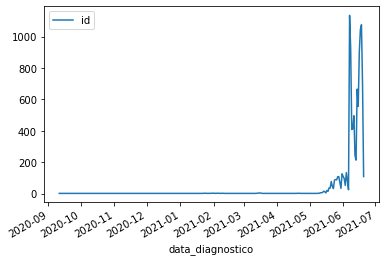

In [23]:
novos_casos = novos_casos_alterado
novos_casos[['id','data_diagnostico']].groupby('data_diagnostico').count().plot()

In [24]:
novos_casos[['id','paciente','sexo','idade','mun_resid', 'mun_atend', 'rs', 'exame_name','data_diagnostico','data_com','data_1o_sintomas','hash_resid']].to_excel(join(default_output,f"novos_casos_{datetime.today().strftime('%Hh')}.xlsx"))

In [25]:
print(len(casos_confirmados), end=' ')
duplicados = casos_confirmados.loc[casos_confirmados.duplicated('hash_resid',keep='first')]
print(f" - {len(duplicados)} ", end='= ')
casos_confirmados = casos_confirmados.drop(index=duplicados.index)
print(len(casos_confirmados))
duplicados.to_excel(join(default_output,'exclusoes.xlsx'))

1192936  - 0 = 1192936


In [26]:
date_parser = lambda x: x
relatorio_file = join(default_output,f"relatorio_{(datetime.today().strftime('%d/%m/%Y_%Hh').replace('/','_').replace(' ',''))}.txt")
# relatorio_file = join(default_output,f"relatorio_all.txt")
relatorio_file

'C:\\sesa\\dev\\output\\relatorio_20_06_2021_13h.txt'

In [27]:
casos_confirmadosPR = casos_confirmados.loc[casos_confirmados['rs']!=99]

obitos_confirmados =  casos_confirmados.loc[casos_confirmados['evolucao']==2]

obitos_confirmadosPR = obitos_confirmados.loc[obitos_confirmados['rs']!=99]

print(f"Total de casos: {len(casos_confirmados)} + {len(novos_casos)}")
print(f"Total de obitos: {len(obitos_confirmados)} + {len(novos_obitos)}\n\n")

novos_casosPR = novos_casos.loc[novos_casos['rs']!=99].copy()
print(f"Total de casos PR: {len(casos_confirmadosPR)} + {len(novos_casosPR)}")

novos_obitosPR = novos_obitos.loc[novos_obitos['rs']!=99].copy()
print(f"Total de obitos PR: {len(obitos_confirmadosPR)} + {len(novos_obitosPR)}")

novos_casosFora = novos_casos.loc[novos_casos['rs']==99].copy()
print(f"Total de casos Fora: {len(casos_confirmados) - len(casos_confirmadosPR)} + {len(novos_casosFora)}")

novos_obitosFora = novos_obitos.loc[novos_obitos['rs']==99].copy()
print(f"Total de obitos Fora: {len(obitos_confirmados) - len(obitos_confirmadosPR)} + {len(novos_obitosFora)}")


novos_obitosPR_group = novos_obitosPR.groupby(by='municipio')

data_retroativos = ontem - timedelta(14)

retroativos = novos_casosPR.loc[(novos_casosPR['data_diagnostico'].apply(date_parser) <= data_retroativos)].sort_values(by='data_diagnostico')
last2weeks = novos_casosPR.loc[(novos_casosPR['data_diagnostico'].apply(date_parser) > data_retroativos) & (novos_casosPR['data_diagnostico'].apply(date_parser) <= anteontem)].sort_values(by='data_diagnostico')
hoje = novos_casosPR.loc[(novos_casosPR['data_diagnostico'].apply(date_parser) > anteontem)].sort_values(by='data_diagnostico')

obitos_retroativos = novos_obitosPR.loc[(novos_obitosPR['data_cura_obito'].apply(date_parser) <= data_retroativos)].sort_values(by='data_cura_obito')
obitos_last2weeks = novos_obitosPR.loc[(novos_obitosPR['data_cura_obito'].apply(date_parser) > data_retroativos) & (novos_obitosPR['data_cura_obito'].apply(date_parser) <= anteontem)].sort_values(by='data_cura_obito')
obitos_hoje = novos_obitosPR.loc[(novos_obitosPR['data_cura_obito'].apply(date_parser) > anteontem)].sort_values(by='data_cura_obito')

# relatorio_file = join(default_output,f"relatorio_{(today.strftime('%d/%m/%Y_%Hh').replace('/','_').replace(' ',''))}.txt")
with codecs.open(relatorio_file,"w","utf-8-sig") as relatorio:
    relatorio.write(f"{today.strftime('%d/%m/%Y')}\n")
    relatorio.write(f"{len(novos_casosPR):,} novos casos residentes ".replace(',','.'))

    if len(novos_casosFora) > 0:
        relatorio.write(f"e {len(novos_casosFora):,} não residente{'s' if len(novos_casosFora) > 1 else ''} ".replace(',','.'))
    relatorio.write(f"divulgados no PR.\n")

    relatorio.write(f"{len(casos_confirmadosPR)+len(novos_casosPR):,} casos confirmados residentes do PR.\n".replace(',','.'))
    relatorio.write(f"{len(casos_confirmados)+len(novos_casos):,} total geral.\n\n".replace(',','.'))
    relatorio.write(f"{len(novos_obitosPR):,} Óbitos residentes do PR:\n".replace(',','.'))

    for municipio, obitos in novos_obitosPR_group:
        relatorio.write(f"{len(obitos):,} {municipio}\n".replace(',','.'))

    if len(novos_obitosFora) > 0:
        relatorio.write('\n')
        relatorio.write(f"{len(novos_obitosFora):,} Óbito{'s' if len(novos_obitosFora) > 1 else ''} não residente{'s' if len(novos_obitosFora) > 1 else ''} do PR.\n".replace(',','.'))

    relatorio.write('\n')
    relatorio.write(f"{len(obitos_confirmadosPR)+len(novos_obitosPR):,} óbitos residentes do PR.\n".replace(',','.'))
    relatorio.write(f"{len(obitos_confirmados)+len(novos_obitos):,} total geral.\n\n".replace(',','.'))

    for _, row in novos_obitos.iterrows():
       relatorio.write(f"{row['sexo']}\t{int(row['idade'])}\t{row['municipio'] if row['rs']!=99 else (row['municipio']+'/'+row['uf'])}\t{str(int(row['rs'])).zfill(2) if row['rs']!=99 else '#N/D'}\t{row['data_cura_obito'].day}/{static.meses[row['data_cura_obito'].month-1]}/{row['data_cura_obito'].year}\n")
    relatorio.write('\n')

    if True:

        #casos
        relatorio.write(f"{len(novos_casosPR):,} novos casos residentes divulgados no PR.\n".replace(',','.'))

        relatorio.write(f"{len(retroativos):,} casos retroativos confirmados no período de {retroativos.iloc[0]['data_diagnostico'].strftime('%d/%m/%Y')} à {retroativos.iloc[-1]['data_diagnostico'].strftime('%d/%m/%Y')}.\n".replace(',','.'))
        relatorio.write(f"{len(last2weeks):,} novos casos confirmados no período de {last2weeks.iloc[0]['data_diagnostico'].strftime('%d/%m/%Y')} à {last2weeks.iloc[-1]['data_diagnostico'].strftime('%d/%m/%Y')}.\n".replace(',','.'))
        relatorio.write(f"{len(hoje):,} novos casos confirmados hoje.\n\n".replace(',','.'))


        novos_casosPR['month'] = novos_casosPR.apply(lambda x: x['data_diagnostico'].month, axis=1)
        novos_casosPR['year'] = novos_casosPR.apply(lambda x: x['data_diagnostico'].year, axis=1)
        relatorio.write('Novos casos por meses:\n')
        for group, value in novos_casosPR.groupby(by=['year','month']):
            relatorio.write(f"{static.meses[int(group[1])-1]}\\{group[0]}: {len(value)}\n")
        relatorio.write('\n')
        
        relatorio.write('Novos casos por dia:\n')
        for group, value in novos_casosPR.groupby(by='data_diagnostico'):
            relatorio.write(f"{group.strftime('%d/%m/%Y')}\t{len(value)}\n")
        relatorio.write('\n')

        #obitos
        relatorio.write(f"{len(novos_obitosPR):,} novos obitos residentes divulgados no PR.\n".replace(',','.'))

        relatorio.write(f"{len(obitos_retroativos):,} obitos retroativos ocorridos no período de {obitos_retroativos.iloc[0]['data_cura_obito'].strftime('%d/%m/%Y')} à {obitos_retroativos.iloc[-1]['data_cura_obito'].strftime('%d/%m/%Y')}.\n".replace(',','.'))
        relatorio.write(f"{len(obitos_last2weeks):,} novos obitos ocorridos no período de {obitos_last2weeks.iloc[0]['data_cura_obito'].strftime('%d/%m/%Y')} à {obitos_last2weeks.iloc[-1]['data_cura_obito'].strftime('%d/%m/%Y')}.\n".replace(',','.'))
        relatorio.write(f"{len(obitos_hoje):,} novos obitos ocorridos hoje.\n\n".replace(',','.'))

        relatorio.write('Novos obitos por meses:\n')
        novos_obitosPR['month'] = novos_obitosPR.apply(lambda x: x['data_cura_obito'].month, axis=1)
        novos_obitosPR['year'] = novos_obitosPR.apply(lambda x: x['data_cura_obito'].year, axis=1)
        for group, value in novos_obitosPR.groupby(by=['year','month']):
            relatorio.write(f"{static.meses[int(group[1])-1]}\\{group[0]}: {len(value)}\n")
        relatorio.write('\n')

        relatorio.write('Novos obitos por dia:\n')
        for group, value in novos_obitosPR.groupby(by='data_cura_obito'):
            relatorio.write(f"{group.strftime('%d/%m/%Y')}\t{len(value)}\n")
        relatorio.write('\n')

        #-----RELATÓRIO DA COMUNICAÇÃO--------------
        obitos_list = []
        munic = []
        for municipio, obitos in novos_obitosPR_group:
            obito = len(obitos)
            obitos_list.append(obito)
            munic.append(municipio)             

        dicionario = (dict(zip(list(munic),list(obitos_list))))
        #print(dicionario)
        dicionario = sorted(dicionario.items(),key=lambda x: x[1], reverse = True)
        #print(dicionario)


        relatorio.write(f"\nOs pacientes que foram a óbito residiam em: ")
        for municip, obit in dict(dicionario).items():
            if obit != 1:
                relatorio.write(f"{municip} ({obit})")
                relatorio.write(f", ")
        relatorio.write(f".\n")
        relatorio.write(f"A Sesa registra ainda a morte de uma pessoa que residia em cada um dos seguintes municípios:")
        for municip, obit in dict(dicionario).items():
            if obit == 1:
                relatorio.write(f"{municip}")
                relatorio.write(f", ")


Total de casos: 1192936 + 10462
Total de obitos: 29975 + 21


Total de casos PR: 1186587 + 10415
Total de obitos PR: 29807 + 21
Total de casos Fora: 6349 + 47
Total de obitos Fora: 168 + 0


In [28]:
with codecs.open(relatorio_file,"r","utf-8-sig") as relatorio:
    print(relatorio.read())

20/06/2021
10.415 novos casos residentes e 47 não residentes divulgados no PR.
1.197.002 casos confirmados residentes do PR.
1.203.398 total geral.

21 Óbitos residentes do PR:
1 Ampére
1 Coronel Vivida
2 Curitiba
2 Londrina
1 Mangueirinha
5 Maringá
1 Rio Negro
7 Sarandi
1 São José dos Pinhais

29.828 óbitos residentes do PR.
29.996 total geral.

F	57	Maringá	15	17/jun/2021
F	47	Ampére	08	18/jun/2021
M	68	Maringá	15	15/jun/2021
F	69	Londrina	17	14/jun/2021
M	49	Sarandi	15	10/jun/2021
M	49	Curitiba	02	17/jun/2021
M	43	Sarandi	15	13/jun/2021
F	61	Sarandi	15	14/jun/2021
F	60	Sarandi	15	13/jun/2021
M	26	São José dos Pinhais	02	18/mai/2021
M	46	Londrina	17	10/jun/2021
M	53	Maringá	15	16/jun/2021
M	101	Maringá	15	18/jun/2021
M	43	Maringá	15	18/jun/2021
F	41	Curitiba	02	16/jun/2021
M	56	Sarandi	15	9/jun/2021
M	68	Sarandi	15	11/jun/2021
F	58	Rio Negro	02	11/jun/2021
F	48	Sarandi	15	15/jun/2021
F	57	Mangueirinha	07	20/jun/2021
M	53	Coronel Vivida	07	19/jun/2021

10.415 novos casos residentes di

In [29]:
from time import sleep
while True:
    sleep(0.3)
    print('a',end='')

aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

KeyboardInterrupt: 

In [30]:
# from pynput.keyboard import Key, Controller

# keyboard = Controller()

# while True:
#     sleep(1)
#     keyboard.press('s')

KeyboardInterrupt: 

In [32]:
cc = CasosConfirmados()
cc.load(f"cc_{ontem.strftime('%d_%m_%Y')}")
casos_confirmados = cc.df
casos_confirmados = casos_confirmados.drop(index=duplicados.index)
casos_confirmados[['identificacao','evolucao']].groupby('evolucao').count()

['cc_19_06_2021']
loading Casos Confirmados from pkl time elepsed:00:00:03


,identificacao
evolucao,
1,832308
2,29975
3,330653


In [44]:
# del novos_casos['uf_residencia']
novos_casos = novos_casos.rename(columns={
    'id':'id_notifica',
    'uf':'uf_residencia',
    'data_com': 'data_comunicacao'
})

novos_casos.loc[~novos_casos['evolucao'].isin([1,2,3]),'evolucao'] = 3
novos_casos.loc[novos_casos['evolucao']==2,'evolucao'] = 3

novos_casos['identificacao'] = list(range(casos_confirmados.iloc[-1,1] + 1,casos_confirmados.iloc[-1,1] + 1 + len(novos_casos)))

novos_casos = novos_casos[['identificacao','id_notifica','uf_residencia','ibge_residencia','ibge_unidade_notifica','paciente','sexo','idade','exame','data_diagnostico','data_comunicacao','data_1o_sintomas','evolucao']]
casos_confirmados = casos_confirmados.append(novos_casos)
print(len(casos_confirmados))
casos_confirmados[['identificacao','evolucao']].groupby('evolucao').count()

1203398


,identificacao
evolucao,
1,833545
2,29975
3,339878


In [45]:
casos_confirmados

,hash_resid,identificacao,id_notifica,uf_residencia,ibge_residencia,ibge_unidade_notifica,paciente,sexo,idade,exame,data_diagnostico,data_comunicacao,data_1o_sintomas,evolucao,data_evolucao,data_com_evolucao,hash_resid_less,hash_resid_more,hash_atend,hash_atend_less,hash_atend_more,hash_diag
0,ELIANACRISTINACUNHADEOLIVEIRASOUZA47410550,8838,-1,PR,410550,410550,ELIANA CRISTINA CUNHA DE OLIVEIRA SOUZA,F,47,LACEN,2020-03-12,2020-03-12,NaT,1,2020-04-03,NaT,ELIANACRISTINACUNHADEOLIVEIRASOUZA46410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA48410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA47410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA46410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA48410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA12032020
1,FLAMARIONPETRIVDEABREU43410690,10932,-1,PR,410690,410690,FLAMARION PETRIV DE ABREU,M,43,LACEN,2020-03-12,2020-03-12,2020-03-07,1,NaT,NaT,FLAMARIONPETRIVDEABREU42410690,FLAMARIONPETRIVDEABREU44410690,FLAMARIONPETRIVDEABREU43410690,FLAMARIONPETRIVDEABREU42410690,FLAMARIONPETRIVDEABREU44410690,FLAMARIONPETRIVDEABREU12032020
2,FLAMARIONPETRIVDEABREUJUNIOR15410690,10933,-1,PR,410690,410690,FLAMARION PETRIV DE ABREU JUNIOR,M,15,LACEN,2020-03-12,2020-03-12,2020-03-08,1,NaT,NaT,FLAMARIONPETRIVDEABREUJUNIOR14410690,FLAMARIONPETRIVDEABREUJUNIOR16410690,FLAMARIONPETRIVDEABREUJUNIOR15410690,FLAMARIONPETRIVDEABREUJUNIOR14410690,FLAMARIONPETRIVDEABREUJUNIOR16410690,FLAMARIONPETRIVDEABREUJUNIOR12032020
3,GABRIELAFUGANTICASAGRANDE26410690,11470,-1,PR,410690,410690,GABRIELA FUGANTI CASAGRANDE,F,26,Genoprimer,2020-03-16,2020-03-12,2020-03-11,1,NaT,NaT,GABRIELAFUGANTICASAGRANDE25410690,GABRIELAFUGANTICASAGRANDE27410690,GABRIELAFUGANTICASAGRANDE26410690,GABRIELAFUGANTICASAGRANDE25410690,GABRIELAFUGANTICASAGRANDE27410690,GABRIELAFUGANTICASAGRANDE16032020
4,GABRIELASCHNEIDERGUGELMIN26410690,11492,-1,PR,410690,410690,GABRIELA SCHNEIDER GUGELMIN,F,26,Genoprimer,2020-03-18,2020-03-12,2020-03-15,1,NaT,NaT,GABRIELASCHNEIDERGUGELMIN25410690,GABRIELASCHNEIDERGUGELMIN27410690,GABRIELASCHNEIDERGUGELMIN26410690,GABRIELASCHNEIDERGUGELMIN25410690,GABRIELASCHNEIDERGUGELMIN27410690,GABRIELASCHNEIDERGUGELMIN18032020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017142,NaN,1288117,3847097,PR,411740,411740,LETICIA VANIA DA SILVA PACHIEGA,F,27,167,2021-05-24,2021-06-20,2021-05-22,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1055981,NaN,1288118,3969092,PR,411930,411930,JULIO CESAR IANQUES,M,44,-1,2021-05-31,2021-06-20,2021-05-21,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1088868,NaN,1288119,4069056,PR,410970,410970,CECILIA YOKO UYEMURA,F,44,167,2021-06-05,2021-06-20,2021-06-02,3,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1069205,NaN,1288120,4010300,PR,410480,410480,REGINALDO FERREIRA DE SOUSA,M,32,167,2021-05-31,2021-06-20,2021-05-27,3,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
cc.df = casos_confirmados
cc.hashes()

In [49]:
casos_confirmados = cc.df
len(casos_confirmados.loc[casos_confirmados['hash_resid'].isin(novos_obitos['hash_resid'])])

21

In [50]:
novos_obitos = novos_obitos.rename(columns={
    'id': 'id_notifica',
    'data_cura_obito': 'data_evolucao',
    'paciente':'nome'
})

novos_obitos['data_com_evolucao'] = pd.to_datetime(date.today())
novos_obitos['evolucao'] = 2

novos_obitos = novos_obitos[['hash_resid','id_notifica','evolucao','data_evolucao','data_com_evolucao']]
novos_obitos = novos_obitos.set_index('hash_resid')
novos_obitos

,id_notifica,evolucao,data_evolucao,data_com_evolucao
hash_resid,,,,
ANAAPARECIDADASILVAZAGATI57411520,4208552,2,2021-06-17,2021-06-20
ANGELAMARIANAVAESCOBAR47410100,4226334,2,2021-06-18,2021-06-20
EDERIVALTERCORDEIROALVES68411520,4145057,2,2021-06-15,2021-06-20
EDNACAETANOMENDES69411370,3465990,2,2021-06-14,2021-06-20
EVERALDOANTONIOSANCHES49412625,4122628,2,2021-06-10,2021-06-20
FLORISVALDOMACEDODOSSANTOS49410690,140993,2,2021-06-17,2021-06-20
GILDOMARTIMOTEODAROSA43412625,4322558,2,2021-06-13,2021-06-20
GLACENILDASANTANA61412625,3735835,2,2021-06-14,2021-06-20
JOANADARCKPALACINI60412625,4322694,2,2021-06-13,2021-06-20


In [51]:
casos_confirmados = casos_confirmados.set_index('hash_resid')
casos_confirmados.update(novos_obitos)
casos_confirmados.reset_index(inplace=True)

print(len(casos_confirmados))
casos_confirmados[['identificacao','evolucao']].groupby('evolucao').count()

1203398


,identificacao
evolucao,
1.0,833545
2.0,29996
3.0,339857


In [52]:
casos_confirmados = casos_confirmados[['identificacao','id_notifica','uf_residencia','ibge_residencia','ibge_unidade_notifica','paciente','sexo','idade','exame','data_diagnostico','data_comunicacao','data_1o_sintomas','evolucao','data_evolucao','data_com_evolucao','hash_resid','hash_resid_less','hash_resid_more','hash_atend','hash_atend_less','hash_atend_more','hash_diag']]
cc.df = casos_confirmados
cc.save(f"cc_{today.strftime('%d_%m_%Y')}", replace=True)
cc.df.tail()

,identificacao,id_notifica,uf_residencia,ibge_residencia,ibge_unidade_notifica,paciente,sexo,idade,exame,data_diagnostico,data_comunicacao,data_1o_sintomas,evolucao,data_evolucao,data_com_evolucao,hash_resid,hash_resid_less,hash_resid_more,hash_atend,hash_atend_less,hash_atend_more,hash_diag
0,8838,-1.0,PR,410550,410550,ELIANA CRISTINA CUNHA DE OLIVEIRA SOUZA,F,47,LACEN,2020-03-12,2020-03-12,NaT,1.0,2020-04-03,NaT,ELIANACRISTINACUNHADEOLIVEIRASOUZA47410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA46410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA48410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA47410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA46410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA48410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA12032020
1,10932,-1.0,PR,410690,410690,FLAMARION PETRIV DE ABREU,M,43,LACEN,2020-03-12,2020-03-12,2020-03-07,1.0,NaT,NaT,FLAMARIONPETRIVDEABREU43410690,FLAMARIONPETRIVDEABREU42410690,FLAMARIONPETRIVDEABREU44410690,FLAMARIONPETRIVDEABREU43410690,FLAMARIONPETRIVDEABREU42410690,FLAMARIONPETRIVDEABREU44410690,FLAMARIONPETRIVDEABREU12032020
2,10933,-1.0,PR,410690,410690,FLAMARION PETRIV DE ABREU JUNIOR,M,15,LACEN,2020-03-12,2020-03-12,2020-03-08,1.0,NaT,NaT,FLAMARIONPETRIVDEABREUJUNIOR15410690,FLAMARIONPETRIVDEABREUJUNIOR14410690,FLAMARIONPETRIVDEABREUJUNIOR16410690,FLAMARIONPETRIVDEABREUJUNIOR15410690,FLAMARIONPETRIVDEABREUJUNIOR14410690,FLAMARIONPETRIVDEABREUJUNIOR16410690,FLAMARIONPETRIVDEABREUJUNIOR12032020
3,11470,-1.0,PR,410690,410690,GABRIELA FUGANTI CASAGRANDE,F,26,Genoprimer,2020-03-16,2020-03-12,2020-03-11,1.0,NaT,NaT,GABRIELAFUGANTICASAGRANDE26410690,GABRIELAFUGANTICASAGRANDE25410690,GABRIELAFUGANTICASAGRANDE27410690,GABRIELAFUGANTICASAGRANDE26410690,GABRIELAFUGANTICASAGRANDE25410690,GABRIELAFUGANTICASAGRANDE27410690,GABRIELAFUGANTICASAGRANDE16032020
4,11492,-1.0,PR,410690,410690,GABRIELA SCHNEIDER GUGELMIN,F,26,Genoprimer,2020-03-18,2020-03-12,2020-03-15,1.0,NaT,NaT,GABRIELASCHNEIDERGUGELMIN26410690,GABRIELASCHNEIDERGUGELMIN25410690,GABRIELASCHNEIDERGUGELMIN27410690,GABRIELASCHNEIDERGUGELMIN26410690,GABRIELASCHNEIDERGUGELMIN25410690,GABRIELASCHNEIDERGUGELMIN27410690,GABRIELASCHNEIDERGUGELMIN18032020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203393,1288117,3847097.0,PR,411740,411740,LETICIA VANIA DA SILVA PACHIEGA,F,27,167,2021-05-24,2021-06-20,2021-05-22,1.0,NaT,NaT,LETICIAVANIADASILVAPACHIEGA27411740,LETICIAVANIADASILVAPACHIEGA26411740,LETICIAVANIADASILVAPACHIEGA28411740,LETICIAVANIADASILVAPACHIEGA27411740,LETICIAVANIADASILVAPACHIEGA26411740,LETICIAVANIADASILVAPACHIEGA28411740,LETICIAVANIADASILVAPACHIEGA24052021
1203394,1288118,3969092.0,PR,411930,411930,JULIO CESAR IANQUES,M,44,-1,2021-05-31,2021-06-20,2021-05-21,1.0,NaT,NaT,JULIOCESARIANQUES44411930,JULIOCESARIANQUES43411930,JULIOCESARIANQUES45411930,JULIOCESARIANQUES44411930,JULIOCESARIANQUES43411930,JULIOCESARIANQUES45411930,JULIOCESARIANQUES31052021
1203395,1288119,4069056.0,PR,410970,410970,CECILIA YOKO UYEMURA,F,44,167,2021-06-05,2021-06-20,2021-06-02,3.0,NaT,NaT,CECILIAYOKOUYEMURA44410970,CECILIAYOKOUYEMURA43410970,CECILIAYOKOUYEMURA45410970,CECILIAYOKOUYEMURA44410970,CECILIAYOKOUYEMURA43410970,CECILIAYOKOUYEMURA45410970,CECILIAYOKOUYEMURA05062021
1203396,1288120,4010300.0,PR,410480,410480,REGINALDO FERREIRA DE SOUSA,M,32,167,2021-05-31,2021-06-20,2021-05-27,3.0,NaT,NaT,REGINALDOFERREIRADESOUSA32410480,REGINALDOFERREIRADESOUSA31410480,REGINALDOFERREIRADESOUSA33410480,REGINALDOFERREIRADESOUSA32410480,REGINALDOFERREIRADESOUSA31410480,REGINALDOFERREIRADESOUSA33410480,REGINALDOFERREIRADESOUSA31052021


In [67]:
# cc.fix_dtypes()
casos_confirmados = cc.df
casos_confirmados

,identificacao,id_notifica,uf_residencia,ibge_residencia,ibge_unidade_notifica,paciente,sexo,idade,exame,data_diagnostico,data_comunicacao,data_1o_sintomas,evolucao,data_evolucao,data_com_evolucao,hash_resid,hash_resid_less,hash_resid_more,hash_atend,hash_atend_less,hash_atend_more,hash_diag
0,8838,-1,PR,410550,410550,ELIANA CRISTINA CUNHA DE OLIVEIRA SOUZA,F,47,LACEN,2020-03-12,2020-03-12,NaT,1,2020-04-03,NaT,ELIANACRISTINACUNHADEOLIVEIRASOUZA47410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA46410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA48410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA47410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA46410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA48410550,ELIANACRISTINACUNHADEOLIVEIRASOUZA12032020
1,10932,-1,PR,410690,410690,FLAMARION PETRIV DE ABREU,M,43,LACEN,2020-03-12,2020-03-12,2020-03-07,1,NaT,NaT,FLAMARIONPETRIVDEABREU43410690,FLAMARIONPETRIVDEABREU42410690,FLAMARIONPETRIVDEABREU44410690,FLAMARIONPETRIVDEABREU43410690,FLAMARIONPETRIVDEABREU42410690,FLAMARIONPETRIVDEABREU44410690,FLAMARIONPETRIVDEABREU12032020
2,10933,-1,PR,410690,410690,FLAMARION PETRIV DE ABREU JUNIOR,M,15,LACEN,2020-03-12,2020-03-12,2020-03-08,1,NaT,NaT,FLAMARIONPETRIVDEABREUJUNIOR15410690,FLAMARIONPETRIVDEABREUJUNIOR14410690,FLAMARIONPETRIVDEABREUJUNIOR16410690,FLAMARIONPETRIVDEABREUJUNIOR15410690,FLAMARIONPETRIVDEABREUJUNIOR14410690,FLAMARIONPETRIVDEABREUJUNIOR16410690,FLAMARIONPETRIVDEABREUJUNIOR12032020
3,11470,-1,PR,410690,410690,GABRIELA FUGANTI CASAGRANDE,F,26,Genoprimer,2020-03-16,2020-03-12,2020-03-11,1,NaT,NaT,GABRIELAFUGANTICASAGRANDE26410690,GABRIELAFUGANTICASAGRANDE25410690,GABRIELAFUGANTICASAGRANDE27410690,GABRIELAFUGANTICASAGRANDE26410690,GABRIELAFUGANTICASAGRANDE25410690,GABRIELAFUGANTICASAGRANDE27410690,GABRIELAFUGANTICASAGRANDE16032020
4,11492,-1,PR,410690,410690,GABRIELA SCHNEIDER GUGELMIN,F,26,Genoprimer,2020-03-18,2020-03-12,2020-03-15,1,NaT,NaT,GABRIELASCHNEIDERGUGELMIN26410690,GABRIELASCHNEIDERGUGELMIN25410690,GABRIELASCHNEIDERGUGELMIN27410690,GABRIELASCHNEIDERGUGELMIN26410690,GABRIELASCHNEIDERGUGELMIN25410690,GABRIELASCHNEIDERGUGELMIN27410690,GABRIELASCHNEIDERGUGELMIN18032020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203393,1288117,3847097,PR,411740,411740,LETICIA VANIA DA SILVA PACHIEGA,F,27,167,2021-05-24,2021-06-20,2021-05-22,1,NaT,NaT,LETICIAVANIADASILVAPACHIEGA27411740,LETICIAVANIADASILVAPACHIEGA26411740,LETICIAVANIADASILVAPACHIEGA28411740,LETICIAVANIADASILVAPACHIEGA27411740,LETICIAVANIADASILVAPACHIEGA26411740,LETICIAVANIADASILVAPACHIEGA28411740,LETICIAVANIADASILVAPACHIEGA24052021
1203394,1288118,3969092,PR,411930,411930,JULIO CESAR IANQUES,M,44,-1,2021-05-31,2021-06-20,2021-05-21,1,NaT,NaT,JULIOCESARIANQUES44411930,JULIOCESARIANQUES43411930,JULIOCESARIANQUES45411930,JULIOCESARIANQUES44411930,JULIOCESARIANQUES43411930,JULIOCESARIANQUES45411930,JULIOCESARIANQUES31052021
1203395,1288119,4069056,PR,410970,410970,CECILIA YOKO UYEMURA,F,44,167,2021-06-05,2021-06-20,2021-06-02,3,NaT,NaT,CECILIAYOKOUYEMURA44410970,CECILIAYOKOUYEMURA43410970,CECILIAYOKOUYEMURA45410970,CECILIAYOKOUYEMURA44410970,CECILIAYOKOUYEMURA43410970,CECILIAYOKOUYEMURA45410970,CECILIAYOKOUYEMURA05062021
1203396,1288120,4010300,PR,410480,410480,REGINALDO FERREIRA DE SOUSA,M,32,167,2021-05-31,2021-06-20,2021-05-27,3,NaT,NaT,REGINALDOFERREIRADESOUSA32410480,REGINALDOFERREIRADESOUSA31410480,REGINALDOFERREIRADESOUSA33410480,REGINALDOFERREIRADESOUSA32410480,REGINALDOFERREIRADESOUSA31410480,REGINALDOFERREIRADESOUSA33410480,REGINALDOFERREIRADESOUSA31052021


In [68]:
municipios = Municipios()

macros_idx_labels = dict([ [i,x] for (i,x) in enumerate(['Leste','Oeste','Noroeste','Norte','Fora'])])
macros_labels_idx = dict([ [x,i] for (i,x) in macros_idx_labels.items() ])
municipios['macro'] = municipios['macro'].apply(lambda x: macros_labels_idx[x])

casos_confirmados = pd.merge(casos_confirmados.rename(columns={'ibge_residencia':'ibge'}),municipios,on=['ibge'],how='left').rename(columns={'ibge':'ibge_residencia'})

casos_confirmados['municipio_pr'] = casos_confirmados['municipio']
casos_confirmados.loc[casos_confirmados['uf_residencia']!='PR','municipio_pr'] = 'Fora'

casos_confirmados.loc[casos_confirmados['uf_residencia']!='PR','ibge7'] = 9999999

casos_confirmados['uf_pr'] = 'PR'
casos_confirmados.loc[casos_confirmados['uf_residencia']!='PR','uf_pr'] = 'Fora'

In [69]:
pd.options.display.float_format = lambda x: '{:,.0f}'.format(x).replace(',','.')

total = casos_confirmados.groupby(['evolucao','uf_pr'])[['sexo']].count().unstack().droplevel(0,1)[['PR','Fora']]
total['GERAL'] = total.sum(1)
total = total.append(pd.Series(total.sum(0),name=0))
total.index = [2,1,3,0]
total = total.sort_index()
total = total.rename(index={0:'CASOS',2:'RECUPERADOS',1:'OBITOS',3:'ATIVOS'})
total.index.name = None
total.columns.name = None

total.astype(float)

,PR,Fora,GERAL
CASOS,1.197.002,6.396,1.203.398
OBITOS,29.828,168,29.996
RECUPERADOS,831.200,2.345,833.545
ATIVOS,335.974,3.883,339.857


In [70]:
total_macros = casos_confirmados.groupby(['macro','evolucao'])[['sexo']].count().unstack()
total_macros.columns = total_macros.columns.droplevel(0)

total_macros['CASOS'] = total_macros.sum(1)
total_macros = total_macros.fillna(0)
total_macros = total_macros.rename(columns={1:'RECUPERADOS',2:'OBITOS',3:'ATIVOS'})
total_macros = total_macros[['CASOS','OBITOS','RECUPERADOS','ATIVOS']]

total_macros.index = [ macros_idx_labels[x] if isinstance(x,int) else x for x in total_macros.index]

total_macros.astype(float)

evolucao,CASOS,OBITOS,RECUPERADOS,ATIVOS
Leste,551.698,14.993,363.990,172.715
Oeste,244.914,5.026,210.183,29.705
Noroeste,197.288,4.355,145.013,47.920
Norte,203.102,5.454,112.014,85.634
Fora,6.396,168,2.345,3.883


In [71]:
total_regionais = casos_confirmados.groupby(['rs','regional','evolucao'])[['sexo']].count().unstack()
total_regionais.columns = total_regionais.columns.droplevel(0)

total_regionais['CASOS'] = total_regionais.sum(1)
total_regionais = total_regionais.fillna(0)
total_regionais = total_regionais.rename(columns={1:'RECUPERADOS',2:'OBITOS',3:'ATIVOS'})
total_regionais = total_regionais[['CASOS','OBITOS','RECUPERADOS','ATIVOS']]

total_regionais.astype(float)

,evolucao,CASOS,OBITOS,RECUPERADOS,ATIVOS
rs,regional,,,,
1,Paranaguá,36.795,933,19.123,16.739
2,Metropolitana,348.983,10.315,240.323,98.345
3,Ponta Grossa,71.258,1.691,46.348,23.219
4,Irati,17.435,357,13.010,4.068
5,Guarapuava,39.003,854,22.853,15.296
6,União da Vitória,13.027,274,9.226,3.527
7,Pato Branco,32.601,765,27.471,4.365
8,Francisco Beltrão,43.994,742,37.308,5.944
9,Foz do Iguaçu,58.210,1.347,46.327,10.536


In [72]:
total_municipios = casos_confirmados.groupby(['macro','rs','regional','ibge7','municipio_pr','evolucao'])[['sexo']].count().unstack()

total_municipios[('','CASOS')] = total_municipios.sum(1)
total_municipios = total_municipios.fillna(0).astype(float)
total_municipios.columns = total_municipios.columns.droplevel(0)
total_municipios = total_municipios.rename(columns={1:'RECUPERADOS',2:'OBITOS',3:'ATIVOS'})
total_municipios = total_municipios[['CASOS','OBITOS','RECUPERADOS','ATIVOS']]

total_municipios.index = total_municipios.index.set_levels([ macros_idx_labels[x] if isinstance(x,int) else x for x in total_municipios.index.levels[0]], level=0)

total_municipios

evolucao                                         CASOS  OBITOS  RECUPERADOS  \
macro rs regional  ibge7   municipio_pr                                       
Leste 1  Paranaguá 4101200 Antonina              2.437      64        2.193   
                   4109500 Guaraqueçaba            650      18          548   
                   4109609 Guaratuba             4.489     161        3.956   
                   4115705 Matinhos              3.121     111        2.638   
                   4116208 Morretes              2.070      52        1.640   
...                                                ...     ...          ...   
Norte 22 Ivaiporã  4122172 Rio Branco do Ivaí      312      11          264   
                   4122651 Rosário do Ivaí         381       2          376   
                   4123857 Santa Maria do Oeste    714      23          624   
                   4125001 São João do Ivaí      1.059      21          884   
Fora  99 Fora      9999999 Fora                  6.396     168        2.345   

evolucao                                         ATIVOS  
macro rs regional  ibge7   municipio_pr                  
Leste 1  Paranaguá 4101200 Antonina                 180  
                   4109500 Guaraqueçaba              84  
                   4109609 Guaratuba                372  
                   4115705 Matinhos                 372  
                   4116208 Morretes                 378  
...                                                 ...  
Norte 22 Ivaiporã  4122172 Rio Branco do Ivaí        37  
                   4122651 Rosário do Ivaí            3  
                   4123857 Santa Maria do Oeste      67  
                   4125001 São João do Ivaí         154  
Fora  99 Fora      9999999 Fora                   3.883  

[400 rows x 4 columns]

In [73]:
ministerio_cols = ['ibge7','municipio_pr','macro','CASOS','OBITOS']

ministerio_sort = pd.read_csv(join(default_input,'ministerio_ibge_order.csv'), sep=';')

ministerio = pd.merge(ministerio_sort, total_municipios.reset_index()[ministerio_cols], how='left', on='ibge7' )
del ministerio['ibge7']

ministerio['macro'] = ministerio['macro'].str.upper()

ministerio.loc[399,['municipio_pr']] = 'Fora do Parana'
ministerio.loc[399,['macro']] = ''

ministerio.loc[400,'municipio_pr'] = 'TOTAL GERAL'
ministerio.loc[400,'macro'] = ''
ministerio.loc[400,'CASOS'] = total.loc['CASOS','GERAL']
ministerio.loc[400,'OBITOS'] = total.loc['OBITOS','GERAL']

ministerio.columns = ['Município de residência', 'macro', 'Casos confirmados', 'Óbitos']

writer = pd.ExcelWriter(join(default_output,"Casos confirmados covid19 no PR por município.xlsx"),
                    engine='xlsxwriter')

ministerio.to_excel(writer,'total_municipios', index=False)
fit_cols(writer,ministerio,'total_municipios')

writer.save()

from openpyxl import load_workbook
from openpyxl.styles import Alignment, PatternFill

wb = load_workbook(filename = join(default_output,"Casos confirmados covid19 no PR por município.xlsx"))
sheet = wb['total_municipios']
sheet.insert_rows(1)
sheet.merge_cells(start_row=1, start_column=1, end_row=1, end_column=4)
cell = sheet.cell(row=1, column=1)  
cell.value = 'Casos confirmados covid-19 no Paraná'  
cell.alignment = Alignment(horizontal='center', vertical='center')  
wb.save(filename = join(default_output,"Casos confirmados covid19 no PR por município.xlsx"))

ministerio

,Município de residência,macro,Casos confirmados,Óbitos
0,Antonina,LESTE,2.437,64
1,Guaraqueçaba,LESTE,650,18
2,Guaratuba,LESTE,4.489,161
3,Matinhos,LESTE,3.121,111
4,Morretes,LESTE,2.070,52
...,...,...,...,...
396,Rosário do Ivaí,NORTE,381,2
397,Santa Maria do Oeste,NORTE,714,23
398,São João do Ivaí,NORTE,1.059,21
399,Fora do Parana,,6.396,168


In [77]:
casos_confirmados['regional'] = casos_confirmados['rs'].apply(lambda x: str(x).zfill(2)) +'ª '+ 'Regional'

casos_confirmados = casos_confirmados[['identificacao', 'id_notifica', 'uf_residencia', 'ibge_residencia', 'ibge_unidade_notifica', 'paciente', 'sexo', 'idade', 'exame', 'data_diagnostico', 'data_comunicacao', 'data_1o_sintomas', 'evolucao', 'data_evolucao', 'data_com_evolucao', 'macro','rs','regional']]

casos_confirmados.loc[casos_confirmados['evolucao']==1,'evolucao'] = 'CURA'
casos_confirmados.loc[casos_confirmados['evolucao']==2,'evolucao'] = 'OBITO'
casos_confirmados.loc[casos_confirmados['evolucao']==3,'evolucao'] = 'ATIVO'
casos_confirmados

,identificacao,id_notifica,uf_residencia,ibge_residencia,ibge_unidade_notifica,paciente,sexo,idade,exame,data_diagnostico,data_comunicacao,data_1o_sintomas,evolucao,data_evolucao,data_com_evolucao,macro,rs,regional
0,8838,-1,PR,410550,410550,ELIANA CRISTINA CUNHA DE OLIVEIRA SOUZA,F,47,LACEN,2020-03-12,2020-03-12,NaT,CURA,2020-04-03,NaT,2,13,13ª Regional
1,10932,-1,PR,410690,410690,FLAMARION PETRIV DE ABREU,M,43,LACEN,2020-03-12,2020-03-12,2020-03-07,CURA,NaT,NaT,0,2,02ª Regional
2,10933,-1,PR,410690,410690,FLAMARION PETRIV DE ABREU JUNIOR,M,15,LACEN,2020-03-12,2020-03-12,2020-03-08,CURA,NaT,NaT,0,2,02ª Regional
3,11470,-1,PR,410690,410690,GABRIELA FUGANTI CASAGRANDE,F,26,Genoprimer,2020-03-16,2020-03-12,2020-03-11,CURA,NaT,NaT,0,2,02ª Regional
4,11492,-1,PR,410690,410690,GABRIELA SCHNEIDER GUGELMIN,F,26,Genoprimer,2020-03-18,2020-03-12,2020-03-15,CURA,NaT,NaT,0,2,02ª Regional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203393,1288117,3847097,PR,411740,411740,LETICIA VANIA DA SILVA PACHIEGA,F,27,167,2021-05-24,2021-06-20,2021-05-22,CURA,NaT,NaT,2,15,15ª Regional
1203394,1288118,3969092,PR,411930,411930,JULIO CESAR IANQUES,M,44,-1,2021-05-31,2021-06-20,2021-05-21,CURA,NaT,NaT,0,5,05ª Regional
1203395,1288119,4069056,PR,410970,410970,CECILIA YOKO UYEMURA,F,44,167,2021-06-05,2021-06-20,2021-06-02,ATIVO,NaT,NaT,3,19,19ª Regional
1203396,1288120,4010300,PR,410480,410480,REGINALDO FERREIRA DE SOUSA,M,32,167,2021-05-31,2021-06-20,2021-05-27,ATIVO,NaT,NaT,1,10,10ª Regional


In [78]:
obitos_confirmados = casos_confirmados.loc[casos_confirmados['evolucao']=='OBITO']

In [ ]:
writer = pd.ExcelWriter(join(default_output, f"casos_{today.strftime('%d_%m_%Y')}.xlsx"),
                    engine='xlsxwriter',
                    datetime_format='dd/mm/yyyy',
                    date_format='dd/mm/yyyy')

total.to_excel(writer,'total')
total_macros.to_excel(writer,'total_macros')
total_regionais.to_excel(writer,'total_regionais')
total_municipios.to_excel(writer,'total_municipios')

fit_cols(writer,total,'total')
fit_cols(writer,total_macros,'total_macros')
fit_cols(writer,total_regionais,'total_regionais')
fit_cols(writer,total_municipios,'total_municipios')

for idx, macro in macros_idx_labels.items():
    casos_macro = casos_confirmados.loc[casos_confirmados['macro']==idx].copy()
    casos_macro['macro'] = macro
    casos_macro.to_excel(writer,macro)
    fit_cols(writer,casos_macro,macro)


writer.save()

In [ ]:
writer = pd.ExcelWriter(join(default_output, f"obitos_{today.strftime('%d_%m_%Y')}.xlsx"),
                    engine='xlsxwriter',
                    datetime_format='dd/mm/yyyy',
                    date_format='dd/mm/yyyy')

total.to_excel(writer,'total')
total_macros.to_excel(writer,'total_macros')
total_regionais.to_excel(writer,'total_regionais')
total_municipios.to_excel(writer,'total_municipios')

fit_cols(writer,total,'total')
fit_cols(writer,total_macros,'total_macros')
fit_cols(writer,total_regionais,'total_regionais')
fit_cols(writer,total_municipios,'total_municipios')

obitos_confirmados.to_excel(writer,'obitos')
fit_cols(writer,obitos_confirmados,'obitos')


writer.save()

In [ ]:
writer = pd.ExcelWriter(join(default_output,f"casos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"),
                    engine='xlsxwriter',
                    datetime_format='dd/mm/yyyy',
                    date_format='dd/mm/yyyy')

total.to_excel(writer,'total')
total_macros.to_excel(writer,'total_macros')
total_regionais.to_excel(writer,'total_regionais')
total_municipios.to_excel(writer,'total_municipios')

fit_cols(writer,total,'total')
fit_cols(writer,total_macros,'total_macros')
fit_cols(writer,total_regionais,'total_regionais')
fit_cols(writer,total_municipios,'total_municipios')

for regional in sorted(casos_confirmados['regional'].unique()):
    casos_regional = casos_confirmados.loc[casos_confirmados['regional']==regional].copy()
    casos_regional['macro'] = casos_regional['macro'].apply(lambda x: macros_idx_labels[x])
    casos_regional.to_excel(writer,regional)
    fit_cols(writer,casos_regional,regional)


writer.save()

In [ ]:
writer = pd.ExcelWriter(join(default_output,f"obitos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"),
                    engine='xlsxwriter',
                    datetime_format='dd/mm/yyyy',
                    date_format='dd/mm/yyyy')

total.to_excel(writer,'total')
total_macros.to_excel(writer,'total_macros')
total_regionais.to_excel(writer,'total_regionais')
total_municipios.to_excel(writer,'total_municipios')

fit_cols(writer,total,'total')
fit_cols(writer,total_macros,'total_macros')
fit_cols(writer,total_regionais,'total_regionais')
fit_cols(writer,total_municipios,'total_municipios')

for regional in sorted(obitos_confirmados['regional'].unique()):
    obitos_regional = obitos_confirmados.loc[obitos_confirmados['regional']==regional].copy()
    obitos_regional['macro'] = obitos_regional['macro'].apply(lambda x: macros_idx_labels[x])
    obitos_regional.to_excel(writer,regional)
    fit_cols(writer,obitos_regional,regional)


writer.save()

In [ ]:
# REMOVE ARQUIVOS DE ONTEM
try:
    remove(join(default_output, f"casos_{ontem.strftime('%d_%m_%Y')}.xlsx"))
    remove(join(default_output, f"obitos_{ontem.strftime('%d_%m_%Y')}.xlsx"))
    remove(join(default_output, f"casos_regionais_{ontem.strftime('%d_%m_%Y')}.xlsx"))
    remove(join(default_output, f"obitos_regionais_{ontem.strftime('%d_%m_%Y')}.xlsx"))

    remove(join(default_output, f"casos_{ontem.strftime('%d_%m_%Y')}.zip"))
    remove(join(default_output, f"obitos_{ontem.strftime('%d_%m_%Y')}.zip"))
    remove(join(default_output, f"casos_regionais_{ontem.strftime('%d_%m_%Y')}.zip"))
    remove(join(default_output, f"obitos_regionais_{ontem.strftime('%d_%m_%Y')}.zip"))
except:
    pass

# GERA ARQUIVOS COMPACTADOS DE HOJE

paths = [join(default_output, f"casos_{today.strftime('%d_%m_%Y')}.xlsx")]
paths.append(join(default_output, f"obitos_{today.strftime('%d_%m_%Y')}.xlsx"))
paths.append(join(default_output, f"casos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"))
paths.append(join(default_output, f"obitos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"))

for path in paths:
    pz.compress(path, None, join(default_output, f"{basename(path)}.zip".replace(".xlsx", "")), "Jt\j+ZXVOAbSw*i&J)ZePVGiQgU4wc", 9)


# REMOVE ARQUIVOS XLSX DE HOJE
remove(join(default_output, f"casos_{today.strftime('%d_%m_%Y')}.xlsx"))
remove(join(default_output, f"obitos_{today.strftime('%d_%m_%Y')}.xlsx"))
remove(join(default_output, f"casos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"))
remove(join(default_output, f"obitos_regionais_{today.strftime('%d_%m_%Y')}.xlsx"))